In [1]:
import pandas as pd
import numpy as np
# load libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
from catboost import CatBoostRegressor

from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedGroupKFold,StratifiedShuffleSplit,KFold,train_test_split

In [ ]:
#data
train=pd.read_csv("../dataset/train_features.csv")
y=pd.read_csv("../dataset/train_labels.csv")
test=pd.read_csv("../dataset/test_features.csv")
ss=pd.read_csv("../dataset/submission_format.csv")

In [3]:
train.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,aace,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.somewhat important,9.Never,9.Never,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2
1,aanz,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,1.Almost every day,0.No,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [4]:
test.head(2)

,uid,age_03,urban_03,married_03,n_mar_03,edu_gru_03,n_living_child_03,migration_03,glob_hlth_03,adl_dress_03,...,rrelgimp_12,rrfcntx_m_12,rsocact_m_12,rrelgwk_12,a16a_12,a21_12,a22_12,a33b_12,a34_12,j11_12
0,abxu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Wood, mosaic, or other covering 1"
1,aeol,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.very important,9.Never,9.Never,1.Yes,NaN,NaN,NaN,NaN,NaN,Concrete 2


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Columns: 184 entries, uid to j11_12
dtypes: float64(140), object(44)
memory usage: 4.6+ MB


In [6]:
#let merge train and label
merged_df = pd.merge(train, y, on='uid', how='left')

In [7]:
#so many missing values
merged_df.isnull().sum()

uid                   0
age_03             1456
urban_03           1454
married_03         1454
n_mar_03           1482
                   ... 
a33b_12            4288
a34_12             1601
j11_12               89
year                  0
composite_score       0
Length: 186, dtype: int64

In [8]:
#lets merged test AND sample submission
merged_test = pd.merge(test, ss, on='uid', how='left')

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

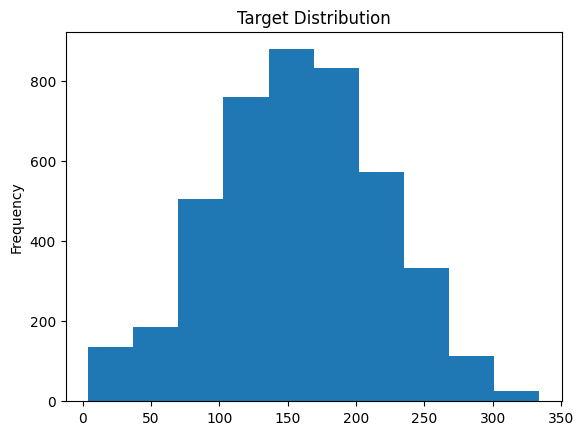

In [9]:
merged_df['composite_score'].plot(kind='hist',title='Target Distribution')

In [10]:
y=merged_df['composite_score']
data=pd.concat((merged_df,merged_test)).reset_index(drop=True).copy()
data=data.drop(columns=['uid','year','composite_score'],axis=1)

In [11]:
# Get the columns with object datatype
object_cols = data.select_dtypes(include=['object']).columns

# Convert the object columns to category dtype
for col in object_cols:
    #data[col] = data[col].astype('category').fillna("Missing")
    data[col] = pd.Categorical(data[col].fillna("Missing"))

In [12]:
#separate train and test
merged_df=data[:len(merged_df)]
merged_test=data[len(merged_df):]

In [13]:
merged_df.shape

(4343, 183)

In [14]:
train_X, val_X, train_y, val_y = train_test_split(merged_df, y,test_size=0.33,random_state=42)

In [15]:
#The model shall handle missing values and encode categorical columns

model = lgb.LGBMRegressor(learning_rate=0.01, n_estimators=1000, random_state=42,
     metric='RMSE')

In [16]:
model.fit(train_X, train_y,  eval_set=(val_X, val_y))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001633 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1493
[LightGBM] [Info] Number of data points in the train set: 2909, number of used features: 183
[LightGBM] [Info] Start training from score 157.069783


LGBMRegressor(learning_rate=0.01, metric='RMSE', n_estimators=1000,
              random_state=42)

In [17]:
#The model shall handle missing values and encode categorical columns
model2 = CatBoostRegressor(
    iterations=10000,
    learning_rate=0.01,
    depth=10,
    loss_function='RMSE',  # Default regression loss
    cat_features=merged_df.select_dtypes(include=['object', 'category']).columns.to_list(),
    verbose=100
)

In [18]:
model2.fit(train_X, train_y,  eval_set=(val_X, val_y))

0:	learn: 60.6238417	test: 60.7096868	best: 60.7096868 (0)	total: 79.1ms	remaining: 13m 11s
100:	learn: 45.4362503	test: 46.6777693	best: 46.6777693 (100)	total: 2.79s	remaining: 4m 33s
200:	learn: 39.1087238	test: 42.1518965	best: 42.1518965 (200)	total: 6.23s	remaining: 5m 3s
300:	learn: 35.4721795	test: 40.4049025	best: 40.4049025 (300)	total: 9.66s	remaining: 5m 11s
400:	learn: 33.1736205	test: 39.5922833	best: 39.5922833 (400)	total: 13s	remaining: 5m 11s
500:	learn: 31.5361084	test: 39.1506785	best: 39.1506785 (500)	total: 16.3s	remaining: 5m 8s
600:	learn: 30.3407622	test: 38.8838031	best: 38.8838031 (600)	total: 19.5s	remaining: 5m 4s
700:	learn: 29.2370283	test: 38.6676094	best: 38.6676094 (700)	total: 22.7s	remaining: 5m 1s
800:	learn: 28.3443365	test: 38.5208261	best: 38.5208261 (800)	total: 26.2s	remaining: 5m
900:	learn: 27.5731562	test: 38.3852428	best: 38.3852428 (900)	total: 29.7s	remaining: 4m 59s
1000:	learn: 26.8687244	test: 38.2887427	best: 38.2887427 (1000)	total: 

In [19]:
pred=model.predict(val_X,num_iteration=model.best_iteration_)

In [21]:
pred

array([213.68477847, 104.80098907, 159.87407169, ..., 147.84512277,
       163.04669509, 121.28910801])

In [89]:
pred2=model2.predict(val_X)

In [90]:
pred2

array([212.7775991 , 116.16479727, 140.39561704, ..., 147.97640025,
       152.88558332, 125.60670099])

In [91]:
from scipy.optimize import minimize

# Placeholder for true target values (replace with your actual data)
true_values = val_y

# Define the loss function for optimization (Mean Squared Error in this case)
def loss_function(weights):
    w1, w2 = weights
    # Compute the weighted predictions
    combined_predictions = w1 * pred + w2 * pred2
    # Calculate Mean Squared Error (replace `true_values` with actual target values)
    mse = np.mean((combined_predictions - true_values) ** 2)
    return mse



# Initial weights
initial_weights = [0.5, 0.5]

# Constraints: weights must sum to 1
constraints = ({'type': 'eq', 'fun': lambda w: w[0] + w[1] - 1})

# Bounds: weights must be between 0 and 1
bounds = [(0, 1), (0, 1)]

# Optimize the weights
result = minimize(loss_function, initial_weights, constraints=constraints, bounds=bounds)

# Get the optimized weights
optimized_weights = result.x


In [92]:
optimized_weights

array([0.14493095, 0.85506905])

In [102]:
# Compute the final weighted predictions using optimized weights
predictions = optimized_weights[0] * pred + optimized_weights[1] * pred2
predictions = np.round(predictions).astype(int)

In [103]:
score =root_mean_squared_error(val_y, predictions)

In [104]:
score

37.53750332942264

In [109]:
#lets generate prediction
fin_pred2 = model2.predict(merged_test)
fin_pred = model.predict(merged_test)

# Compute the final weighted predictions using optimized weights
predictions = optimized_weights[0] * fin_pred + optimized_weights[1] * fin_pred2

In [110]:
predictions

array([171.08600992, 207.35459434, 207.35459434, ..., 185.22871202,
       185.22871202, 145.20543645])

In [113]:
ss.head()


,uid,year,composite_score
0,abxu,2016,171
1,aeol,2016,207
2,aeol,2021,207
3,afnb,2016,195
4,afnb,2021,195


In [ ]:
ss['composite_score']=np.round(predictions).astype(int)
#generate submission
ss.to_csv('../dataset/LGBMCatBoost.csv', index=False)